# Assignment 2 - Exercise 17

Daskalopoulos Ioannis (f3351805)<br>
Ntouskas Fotios (f3351813)<br>
Palassopoulos Vasileios (f3351814)<br>
Spantouri Natalia (f3351817)<br>

## Importing Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import itertools
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
import pprint
from sklearn.feature_selection import mutual_info_classif, SelectKBest

#Get root folder, Extensions that will be read, Class Label
def read_data(directory,file_extension,class_label):
    
    data = []
    index = []
    #Recursively read file paths starting from root directory, ending with the specisfied extension, 2 levels deep
    for filename in glob.glob(directory+'/**/*'+file_extension, recursive=True):
        email_content = ""                                                   #This is our email string
        with open(filename, 'r',encoding='utf-8', errors='ignore') as email: #Open the file in the located file path
            for line in email:                        #Read the email line by line and replace the tabs and new lines with space
                line = line.replace('\n', ' ')
                line = line.replace('\t', ' ')
                email_content+= line                               #Append the line to the email string
        email.close()                                              #Close the file
        data.append({'text': email_content, 'label': class_label}) #Append a dictionary with email string and class label
        index.append(filename)                                     #Append the path
                    
    return data,index

## Reading Emails Recursively by Class

In [2]:
Enron_dataset_dir = os.getcwd() + "\\Enron_dataset" #Path
Ham_data,index_hamdata = read_data(Enron_dataset_dir,".ham.txt","Ham")           #Create array with Ham emails
Spam_data,index_spamdata = read_data(Enron_dataset_dir,".spam.txt","Spam")       #Create array with Spam emails
data = pd.DataFrame(Ham_data,index =index_hamdata)                               #Make them a dataframe with their path as the index
data = data.append(pd.DataFrame(Spam_data,index =index_spamdata))                #Append the spam data
#shufle dataframe      
data = shuffle(data,random_state = 456987)                                       
pd.set_option("max_colwidth",2000)                                               #Set max columns to not overload Jupyter
data.head(5)

,label,text
C:\Users\Fotis\Desktop\Text\Enron_dataset\enron4\spam\1306.2004-05-29.GP.spam.txt,Spam,Subject: re : are you still online ? click here to be removed
C:\Users\Fotis\Desktop\Text\Enron_dataset\enron4\spam\0347.2004-02-05.GP.spam.txt,Spam,"Subject: hi if you are paying more than 3 . 6 % on your mortgage , we can save you money ! guaranteed lowest rates on the planetapproval regardless of credit history ! start saving todayshow me the lowest rates to stop receiving offers here"
C:\Users\Fotis\Desktop\Text\Enron_dataset\enron6\spam\2646.2005-01-11.BG.spam.txt,Spam,"Subject: urgent hi , i hereby wish to inform you that i am interested to purchase your , pci cardteac cd - w 54 e cd - r / rw burner , sony sdt - 5000 dds 2 ( 4 / 8 gb ) dat drive , sony 15 cl dds dat cleaning tape . what is your best offer ? are you the real owner ? what is the condition ? payment will be by money order . dont worried yourself about the pick up . i will take care of that when payment is done . if its still available for sale , provide the details below with which the payment will be sent to . . . offeri look forward to read from you soonest . cheers _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ do you yahoo ! ? tired of spam ? yahoo ! mail has the best spam protection around http : / / mail . yahoo . com"
C:\Users\Fotis\Desktop\Text\Enron_dataset\enron2\ham\3439.2000-11-27.kaminski.ham.txt,Ham,"Subject: transmission roundtable meeting the meeting will be held on december 8 , 2000 from 11 : 30 am to 1 : 00 pm in conference room eb 19 cl . box lunches will be served . your choices are listed below : salads : roasted chicken cobb salad , grilled chicken caesar salad , classic chef salad sandwiches : turkey , roast beef , ham , chicken salad , tuna salad or club sandwich . served on homemade white or wheat bread please email your lunch choice to me by monday , december 4 , 2000 . thanks and regards , anita dupont"
C:\Users\Fotis\Desktop\Text\Enron_dataset\enron3\ham\4567.2001-12-13.kitchen.ham.txt,Ham,"Subject: ask jeeves louise , for the record , ask jeeves was a better investment than enron ! - dan"


In [3]:
data.shape
data['label'].value_counts()

Spam    17171
Ham     16545
Name: label, dtype: int64

## Splitting into Test and Train sets

In [4]:
train, test = train_test_split(data, test_size = 0.3,random_state=1596, stratify=data[['label']].values.tolist()) #0.7 to the train, 0.3 to the test 

X_train = list(itertools.chain.from_iterable(train[['text']].values.tolist())) #Extract x_train from the train set
X_test = list(itertools.chain.from_iterable(test[['text']].values.tolist()))   #Extract x_test from the test set

y_train = list(itertools.chain.from_iterable(train[['label']].values.tolist())) #Extract training labels
le = preprocessing.LabelEncoder()                                               #Initialize Labelencoder
le.fit(y_train)                                                                 
y_train = le.transform(y_train)                                                 #Y_train classes become 0 and 1
y_test = le.transform(list(itertools.chain.from_iterable(test[['label']].values.tolist()))) #Same for y_test

## Converting n-grams into TF-IDF features

In [5]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features = 5000,sublinear_tf=True, stop_words='english', lowercase=True)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## Feature Selection

In [6]:
KBest = SelectKBest(mutual_info_classif, k=4500).fit(X_train_tfidf, y_train)
x_train_tfidf = KBest.transform(X_train_tfidf)
x_test_tfidf = KBest.transform(X_test_tfidf)

In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from scipy.stats import uniform
from sklearn.metrics import f1_score, precision_recall_curve, auc
from sklearn.model_selection import learning_curve, ShuffleSplit, KFold

## Function Predicting the F1 scores

In [8]:
def model_F1(clf):
    predictions = clf.fit(x_train_tfidf, y_train).predict(x_train_tfidf)
    print("train f1-score:",f1_score(y_train,predictions))

    predictions_test = clf.predict(x_test_tfidf)
    print("test f1-score:",f1_score(y_test, predictions_test))
    print()
    print("test data confusion matrix")
    y_true = pd.Series(y_test, name='True')
    y_pred = pd.Series(predictions_test, name='Predicted')
    display(pd.crosstab(y_true, y_pred))

## Baseline classifier

In [9]:
model_F1(DummyClassifier(strategy='most_frequent'))

train f1-score: 0.674882793857556
test f1-score: 0.6748329621380846

test data confusion matrix


Predicted,1
True,
0,4964
1,5151


## Naive-Bayes classifier

In [10]:
model_F1(MultinomialNB())

train f1-score: 0.9835631184531943
test f1-score: 0.9832046332046332

test data confusion matrix


Predicted,0,1
True,,
0,4848,116
1,58,5093


## Logistic Regression - RandomizedSearchCV

In [11]:
logistic = LogisticRegression()
hyperparameters = dict(
    C=uniform(loc=0, scale=4), 
    penalty=['l1', 'l2'], 
    #solver=['newton-cg','lbfgs', 'liblinear', 'sag', 'saga']
    solver=['liblinear']
)

clf = RandomizedSearchCV(logistic, hyperparameters, random_state=1, n_iter=100, cv=5, verbose=0, n_jobs=-1)
best_model = clf.fit(x_train_tfidf, y_train)

print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best Solver:', best_model.best_estimator_.get_params()['solver'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best Solver: liblinear
Best C: 3.87304630287759


In [12]:
model_F1(LogisticRegression(penalty='l2',solver='liblinear' , C=3.873))

train f1-score: 0.9958106931021611
test f1-score: 0.9903362968689602

test data confusion matrix


Predicted,0,1
True,,
0,4891,73
1,27,5124


## SVC - RandomizedSearchCV

In [13]:
sv_classif = svm.SVC(kernel='linear')

hyperparameters = dict(
    C=uniform(2, 10), 
)

clf = RandomizedSearchCV(sv_classif, hyperparameters, random_state=1, n_iter=30, cv=5, verbose=0, n_jobs=-1)
best_model = clf.fit(x_train_tfidf, y_train)

print('Best C:', best_model.best_estimator_.get_params()['C'])

Best C: 2.001143748173449


In [14]:
model_F1(svm.SVC(kernel='linear', C=2))

train f1-score: 0.9969276758282819
test f1-score: 0.9904190457756702

test data confusion matrix


Predicted,0,1
True,,
0,4899,65
1,34,5117


## KNN - GridSearchCV

In [15]:
knn_classif = KNeighborsClassifier(n_jobs=-1)

hyperparameters = dict(
    n_neighbors=list(range(1,15)),
    p=[1,2]
)

clf = GridSearchCV(knn_classif, hyperparameters, cv=5, verbose=0, n_jobs=-1)
best_model = clf.fit(x_train_tfidf, y_train)

print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best power:', best_model.best_estimator_.get_params()['p'])

Best n_neighbors: 2
Best power: 2


In [16]:
model_F1(KNeighborsClassifier(n_neighbors=2, p=2, n_jobs=-1))

train f1-score: 0.9989595038914555
test f1-score: 0.8185727938834024

test data confusion matrix


Predicted,0,1
True,,
0,2698,2266
1,12,5139


## LGBM (Boosted Trees) - RandomizedSearchCV

In [17]:
lgb_classif = LGBMClassifier(n_jobs=-1)

hyperparameters = dict(
    n_estimators=np.arange(1000,3100,100),
    num_leaves=np.arange(5,20,1),
    colsample_bytree=np.linspace(0.05,1,20),
    subsample=np.linspace(0.05,1,20),
    max_depth=np.arange(5,9,1),
    reg_alpha=np.linspace(0.05,0.5,10),
    reg_lambda=np.linspace(0.05,0.5,10),
    min_split_gain=np.linspace(0.05,0.5,10)
)

clf = RandomizedSearchCV(lgb_classif, hyperparameters, random_state=1, n_iter=30, cv=5, verbose=0, n_jobs=-1)
best_model = clf.fit(x_train_tfidf, y_train)

print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best num_leaves:', best_model.best_estimator_.get_params()['num_leaves'])
print('Best colsample_bytree:', best_model.best_estimator_.get_params()['colsample_bytree'])
print('Best subsample:', best_model.best_estimator_.get_params()['subsample'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best reg_alpha:', best_model.best_estimator_.get_params()['reg_alpha'])
print('Best reg_lambda:', best_model.best_estimator_.get_params()['reg_lambda'])
print('Best min_split_gain:', best_model.best_estimator_.get_params()['min_split_gain'])

Best n_estimators: 2600
Best num_leaves: 10
Best colsample_bytree: 0.05
Best subsample: 0.2
Best max_depth: 5
Best reg_alpha: 0.35000000000000003
Best reg_lambda: 0.2
Best min_split_gain: 0.05


In [18]:
model_F1(LGBMClassifier(n_estimators=2600,num_leaves=10,colsample_bytree=0.05,subsample=0.2,max_depth=5,reg_alpha=0.35,reg_lambda=0.2,min_split_gain=0.05))

train f1-score: 0.9984630083496033
test f1-score: 0.9868928296067849

test data confusion matrix


Predicted,0,1
True,,
0,4859,105
1,31,5120


## Stacked Averaged Models

In [19]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)
    
    def predict_proba(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict_proba(meta_features)

In [20]:
logistic = LogisticRegression(penalty='l2',solver='lbfgs' , C=3.873)
SVC = svm.SVC(kernel='linear', C=2, gamma=0.4)
LGBM = LGBMClassifier(colsample_bytree=0.5, gamma=0.045, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.8, n_estimators=2200,
                             reg_alpha=0.45, reg_lambda=0.85,
                             subsample=0.5, silent=1,
                             random_state =7, nthread = -1,
                             n_jobs=-1)
model_F1(StackingAveragedModels(base_models = (LGBM, SVC), meta_model = logistic))

train f1-score: 0.9952339508475279
test f1-score: 0.989284679988416

test data confusion matrix


Predicted,0,1
True,,
0,4880,84
1,27,5124


## Plotting Learning Curves

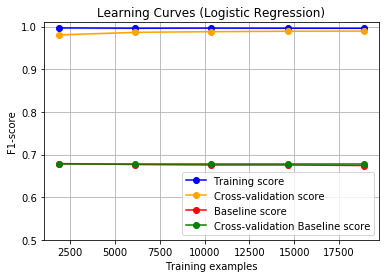

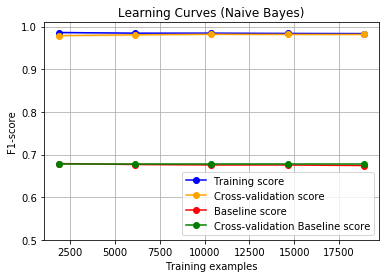

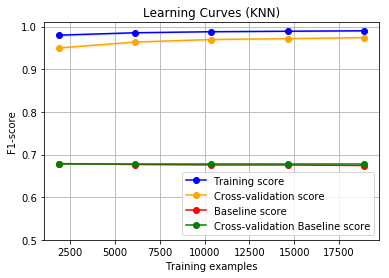

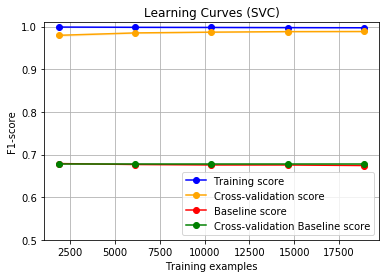

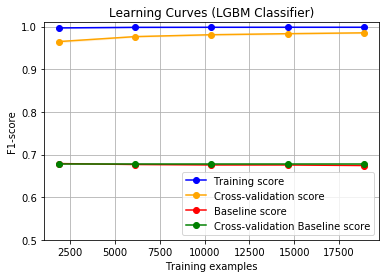

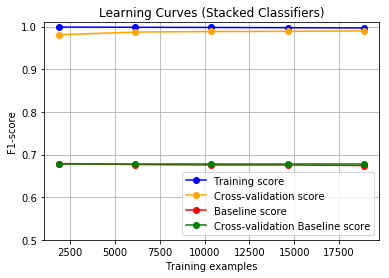

In [21]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title('Learning Curves (%s)' % (name))
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1-score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,scoring='f1', train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange",
             label="Cross-validation score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        DummyClassifier(strategy='most_frequent'), X, y, cv=cv, n_jobs=n_jobs,scoring='f1', train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Baseline score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="green", 
             label="Cross-validation Baseline score")

    plt.legend(loc="lower right")
    return plt


X, y = X_train_tfidf,y_train

estimators = {'Logistic Regression':LogisticRegression(penalty='l2',solver='lbfgs' , C=3.873), 
              'Naive Bayes':MultinomialNB(), 'KNN':KNeighborsClassifier(n_neighbors=2, p=2, n_jobs=-1),
             'SVC':svm.SVC(kernel='linear', C=2),
             'LGBM Classifier':LGBMClassifier(n_estimators=2600, num_leaves=10, colsample_bytree=0.05,
                             subsample=0.2,max_depth=5,reg_alpha=0.35,reg_lambda=0.2,min_split_gain=0.05),
             'Stacked Classifiers': StackingAveragedModels(base_models = (LGBM, SVC), meta_model = logistic)}
                                   
for (name,estimator) in estimators.items():
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    plot_learning_curve(estimator, name, X, y, ylim=(0.5, 1.01), cv=cv, n_jobs=-1)
    plt.show()

## Plotting Precision Recall Curves

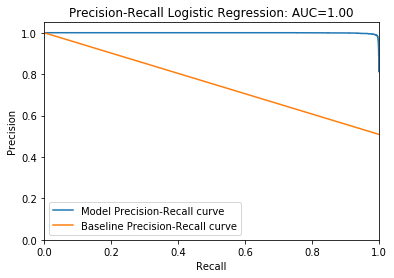

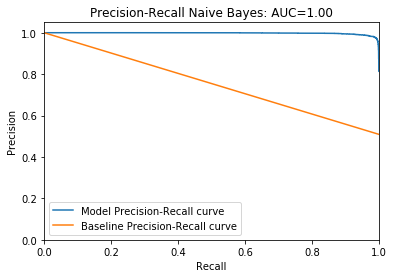

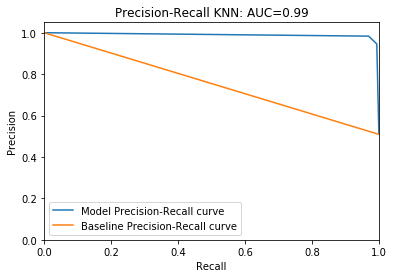

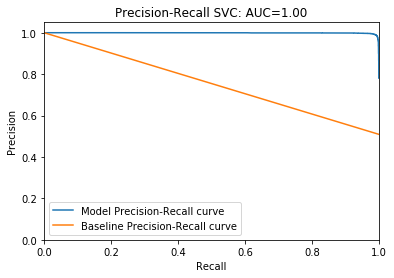

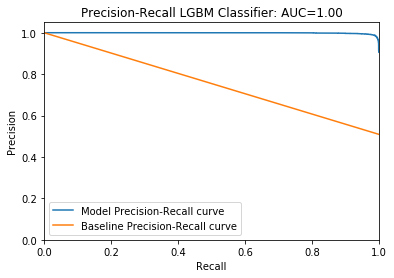

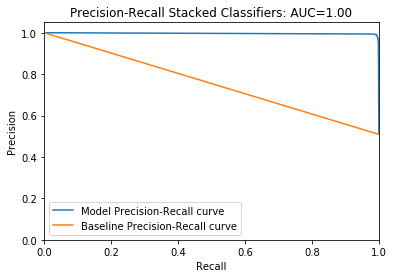

In [22]:
np.seterr(all='ignore')
estimators = {'Logistic Regression':LogisticRegression(penalty='l2',solver='lbfgs' , C=3.873), 
              'Naive Bayes':MultinomialNB(), 'KNN':KNeighborsClassifier(n_neighbors=2, p=2, n_jobs=-1),
             'SVC':svm.SVC(kernel='linear', C=2, probability=True),
             'LGBM Classifier':LGBMClassifier(n_estimators=2600, num_leaves=10, colsample_bytree=0.05,
                             subsample=0.2,max_depth=5,reg_alpha=0.35,reg_lambda=0.2,min_split_gain=0.05),
             'Stacked Classifiers': StackingAveragedModels(base_models = (LGBM, SVC), meta_model = logistic)
             }

for (name,estimator) in estimators.items():
    
    pred = estimator.fit(X_train_tfidf,y_train).predict_proba(X_test_tfidf)
    precision, recall, thresholds = precision_recall_curve(y_test, pred[:,1])
    area = auc(recall, precision)

    plt.plot(recall, precision, label='Model Precision-Recall curve')
    
    pred = DummyClassifier(strategy='most_frequent').fit(X_train_tfidf,y_train).predict_proba(X_test_tfidf)
    precision, recall, thresholds = precision_recall_curve(y_test, pred[:,1])
    
    plt.plot(recall, precision, label='Baseline Precision-Recall curve')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall %s: AUC=%0.2f' % (name,area))
    plt.legend(loc="lower left")
    plt.show()